In [1]:
from stackrecommender import Recommender
from stacksite import StackSite
import numpy as np
import pandas as pd
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import warnings
import sys, time
try:
    import cPickle as pkl
except:
    import pickle as pkl
import bz2
from tqdm import *
import sklearn.metrics
#import numbapro
import pathos.multiprocessing as pmp
import datetime

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
site_name = 'datascience.stackexchange.com'
site = StackSite(site_name)
site.load()
df_dict = site.df_dict()

Dataframes successfully loaded.


In [3]:
users_df = site.df('users').drop('-999')
answers_df = site.df('answers')[site.df('answers').user_id != '-999']
questions_df = site.df('questions').copy()
df_dict['users'] = users_df
df_dict['answers'] = answers_df
df_dict['questions'] = questions_df

In [4]:
rc = Recommender(site_name)
rc.load('full')

Loading the model...
 ...LDA model loaded.
 ...question LDA vectors loaded.
Successfully loaded the recommender.


In [5]:
df_names = ['answers', 'comments']
df_lengths = {name:len(df_dict[name]) for name in df_names}
print df_lengths

# generate the train/test split index arrays
n_folds = 5
folds = {name:KFold(df_lengths[name], n_folds=n_folds) for name in df_names}

# generate the train/test dataframes
train_dfs = {name:[] for name in df_names}
test_dfs = {name:[] for name in df_names}
for name in df_names:
    for train, test in folds[name]:
        train_dfs[name].append(df_dict[name].ix[train])
        test_dfs[name].append(df_dict[name].ix[test])
        
for j in range(1):
    print "train/test split:", len(train_dfs['answers'][j]), len(test_dfs['answers'][j])
    
# split questions_df according to the train/test split of answers_df (pain in the ass,
# but I want to honestly retrain the LDA model each fold)
train_dfs['questions'] = range(n_folds)
test_dfs['questions'] = range(n_folds)
questions_df = site.df('questions').copy()
questions_df['full_question'] = questions_df.title + " " + questions_df.question

for j in range(n_folds):
    train_qids = train_dfs['answers'][j].parent_id.unique().tolist() # indices are already unique
    test_qids = test_dfs['answers'][j].parent_id.unique().tolist() # but df.index is mutable and not hashable
    train_dfs['questions'][j] = questions_df.ix[train_qids]
    test_dfs['questions'][j] = questions_df.ix[test_qids]
    
# pack the training sets into dictionaries of dataframes for the recommender
df_names.append('questions')
train_df_dicts = range(n_folds)
for j in range(n_folds):
    train_df_dicts[j] = {name:train_dfs[name][j] for name in df_names}
    train_df_dicts[j]['tags'] = site.df('tags')
    train_df_dicts[j]['users'] = site.df('users')
    
tags_df = site.df('tags').copy()

{'comments': 1045, 'answers': 644}
train/test split: 515 129


In [6]:
class ZeroClassifier(object):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return
    
    def predict(self, X):
        return 0.
    
    def predict_proba(self, X):
        return np.array([[1.,0.]])

In [19]:
users_

displayname  reputation  \
user_id                                     
-1                  Community           1   
1                   Anna Lear         101   
2                Geoff Dalgas         101   
3                  hichris123         101   
4                 Ben Collins         101   
5                    Doorknob         134   
6                      gerrit         101   
7                        Undo         101   
8                 Jon Ericson         101   
9                       rolfl         404   
10               Dave Kincaid         101   
11                      Yavar         121   
12              abby hairboat         101   
13                  shidangai           1   
14                Tim Goodman         453   
15                       Tony         101   
16               Jeremy Banks         101   
17          Matias Valdenegro         101   
18                     Gilles         101   
19                  Max Ionov         101   
20                  TheDoctor         101   
21                  Sean Owen         935   
22       Nicholas R. Peterson         233   
23                      zengr         101   
24                 buruzaemon         105   
25                       kabb         101   
26                     Alex I         921   
27                       Cole         101   
28               JorgeArtware         101   
29                Eric Wilson         101   
...                       ...         ...   
3269                 Bernhard           1   
3270                Lowe Rudd           1   
3271                  unknown         101   
3272                stoneyang           1   
3273            Eliott Wiener           1   
3274              pentandrous           1   
3275          Micah A. Norman           1   
3276             hernanavella           1   
3277                   ghtdak           1   
3278                     Mr G           1   
3279            MarkKGreenway         106   
3280            jubert roldan           1   
3281                   Guforu           1   
3282                 rhasarub           1   
3283                   Paul K         106   
3284                  Hendrik         116   
3285                      HGS           1   
3286                     Muqo         101   
3287                quasivivo         101   
3288                    LJ001           1   
3289                  rossini          11   
3290              Blue Marker           1   
3291                   Bill B         101   
3292                     Raza         101   
3293              user3775699           1   
3294                  charles         121   
3295            tttthomasssss         101   
3296                   Papa G           1   
3297                    nosmo           1   
3298                user10853           1   

                                                       clf  \
user_id                                                      
-1       <__main__.ZeroClassifier object at 0x7f3a94d32...   
1        <__main__.ZeroClassifier object at 0x7f3a94d32...   
2        <__main__.ZeroClassifier object at 0x7f3a94d32...   
3        <__main__.ZeroClassifier object at 0x7f3a94d32...   
4        <__main__.ZeroClassifier object at 0x7f3a94d32...   
5        <__main__.ZeroClassifier object at 0x7f3a94d32...   
6        <__main__.ZeroClassifier object at 0x7f3a94d32...   
7        <__main__.ZeroClassifier object at 0x7f3a94d32...   
8        <__main__.ZeroClassifier object at 0x7f3a94d32...   
9        (DecisionTreeClassifier(compute_importances=No...   
10       <__main__.ZeroClassifier object at 0x7f3a94d32...   
11       (DecisionTreeClassifier(compute_importances=No...   
12       <__main__.ZeroClassifier object at 0x7f3a94d32...   
13       <__main__.ZeroClassifier object at 0x7f3a94d32...   
14       (DecisionTreeClassifier(compute_importances=No...   
15       <__main__.ZeroClassifier object at 0x7f3a94d32...   
16       <__main__.ZeroClassifier object at 0x7f3a94d32...   
17  

In [7]:
class DotClassifier(object):
    
    def __init__(self):
        self.vec = 0.
        return
    
    def fit(self, X, y):
        if y == 0:
            self.vec = np.zeros_like(X)
        else:
            self.vec = X
        return
    
    def predict(self, X):
        return cosine_similarity(self.vec,X) > 0.5
    
    def predict_proba(self, X):
        a = cosine_similarity(self.vec,X)
        return np.array([[1-a, a]])

In [9]:
# parameters for the run
cutoff = 3 # min score of a 'good' answer
threshold = 0.5 # threshold for positive classification
num_topics = 100
iterations = 1000
passes = 1
tfidf = False
# model_clf = LogisticRegression(fit_intercept = False, penalty = 'l2')
# model_clf = RandomForestClassifier() 

In [10]:
results = [0] * n_folds
n_folds_to_train = 5

# train the LDA model on the fold?
train_LDA = False

# set the number of workers
multiprocessing = True
n_procs = 7

def make_poolmap(multiprocessing=True, n_procs=7):
    if multiprocessing:
        pool = pmp.Pool(n_procs)
        return pool.map
    else:
        return map

start_time = time.time()
for i in range(n_folds_to_train):
    
    print "\nFold %d/%d" % (i+1, n_folds)
    sys.stdout.flush()
    
    if train_LDA: 
        rc = Recommender(site_name, df_dict = train_df_dicts[i])
    rc.train(num_topics = num_topics, iterations = iterations, 
             passes = passes, multicore = True, tfidf = tfidf,
             train_LDA = train_LDA)

    #reset the classifiers and setup new user groups
    users_df['clf'] = ZeroClassifier()
    users_df['X'] = None
    users_df['y'] = None
    user_gps = train_dfs['answers'][i].groupby('user_id')
    users_df.clf.ix[user_gps.groups.keys()] = [model_clf for _ in xrange(len(user_gps.groups.keys()))]
    
    # do logistic regression for each user
    print "Fitting..."
    sys.stdout.flush()
    
    print " ...creating training vectors."
    sys.stdout.flush()
    
    def make_X(user):
        questions = questions_df.full_question.ix[user_gps.get_group(user).parent_id]
        LDAvec = rc.post2LDAvec(questions)
        vec = rc.LDAvec2ndarray(LDAvec)
        scores = user_gps.get_group(user).score[:,np.newaxis]
        X = np.vstack([np.zeros(rc.LDAmodel.num_topics),
                                np.ones(rc.LDAmodel.num_topics) / rc.LDAmodel.num_topics,
                                vec*scores])
        return X

    def make_y(user):
        y = np.concatenate([[0,1],(user_gps.get_group(user).score >= cutoff).values])
        return y

    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    users_df['X'].ix[user_gps.groups.keys()] = my_map(make_X, user_gps.groups.keys())     
    
    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    users_df['y'].ix[user_gps.groups.keys()] = my_map(make_y, user_gps.groups.keys())
    
    print " ...done creating training vectors."
    print " ...fitting the classifiers."
    sys.stdout.flush()
    
    #my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    def fita(user_id):
        users_df.clf.ix[user_id].fit(users_df.X.ix[user_id],users_df.y.ix[user_id])
        return
    map(fita, user_gps.groups.keys())
    
    print " ...done fitting."
    print "Testing..."
    sys.stdout.flush()

    # build the test LDA vectors
    test_dfs['questions'][i]['feature_vec'] = test_dfs['questions'][i].title + " " + test_dfs['questions'][i].question
    test_dfs['questions'][i]['feature_vec'] = test_dfs['questions'][i]['feature_vec'].apply(rc.post2LDAvec)
    test_dfs['questions'][i]['feature_vec'] = test_dfs['questions'][i]['feature_vec'].apply(rc.LDAvec2ndarray)
    print " ... built LDA vectors."
    sys.stdout.flush()

    # compute the results of the fold
    results[i] = pd.DataFrame()
    results[i]['actual'] = test_dfs['answers'][i].score.values >= cutoff
    results[i]['predicted'] = 0.
    results[i]['proba'] = 0.
    print " ... recording results."
    sys.stdout.flush()

    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    def predicta(a):
        return a[0].predict_proba(a[1])[0][1]
    results[i]['proba'] = my_map(predicta, 
                                zip(users_df.clf.ix[test_dfs['answers'][i].user_id], 
                                test_dfs['questions'][i].feature_vec.ix[test_dfs['answers'][i].parent_id]))
    
    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    def thresha(a):
        return (a > threshold)
    results[i]['predicted'] = my_map(thresha, results[i]['proba'])
    
    print "Done!"
    sys.stdout.flush()

full_results = pd.DataFrame(data={'actual':np.concatenate([x.actual for x in results[:n_folds_to_train]]), 
                                  'predicted':np.concatenate([x.predicted for x in results[:n_folds_to_train]]),
                                  'proba':np.concatenate([x.proba for x in results[:n_folds_to_train]])})

print "\nnumber of folds trained %d/%d" % (n_folds_to_train, n_folds)
print "cutoff =", cutoff
print "num_topics =", num_topics
print model_clf
print "Precision: %.2f" % (sklearn.metrics.precision_score(full_results.actual,full_results.predicted))
print "Recall: %.2f" % (sklearn.metrics.recall_score(full_results.actual,full_results.predicted))
print "ROC-AUC: %.2f" % (sklearn.metrics.roc_auc_score(full_results.actual, full_results.proba))
print 

end_time = time.time()
print "Time: ", str(datetime.timedelta(seconds=(end_time-start_time)))


Fold 1/5
Training...
 ...created the dictionary.
 ...vectorized the corpus.
 ...training the LDA model on 100 topics in 1 passes and 1000 iterations.


 ...trained the LDA model.
Done training!
Fitting...
 ...creating training vectors.
 ...done creating training vectors.
 ...fitting the classifiers.
 ...done fitting.
Testing...
 ... built LDA vectors.
 ... recording results.
Done!

Fold 2/5
Training...
 ...created the dictionary.
 ...vectorized the corpus.
 ...training the LDA model on 100 topics in 1 passes and 1000 iterations.


 ...trained the LDA model.
Done training!
Fitting...
 ...creating training vectors.
 ...done creating training vectors.
 ...fitting the classifiers.
 ...done fitting.
Testing...
 ... built LDA vectors.
 ... recording results.
Done!

Fold 3/5
Training...
 ...created the dictionary.
 ...vectorized the corpus.
 ...training the LDA model on 100 topics in 1 passes and 1000 iterations.


 ...trained the LDA model.
Done training!
Fitting...
 ...creating training vectors.
 ...done creating training vectors.
 ...fitting the classifiers.
 ...done fitting.
Testing...
 ... built LDA vectors.
 ... recording results.
Done!

Fold 4/5
Training...
 ...created the dictionary.
 ...vectorized the corpus.
 ...training the LDA model on 100 topics in 1 passes and 1000 iterations.


 ...trained the LDA model.
Done training!
Fitting...
 ...creating training vectors.
 ...done creating training vectors.
 ...fitting the classifiers.
 ...done fitting.
Testing...
 ... built LDA vectors.
 ... recording results.
Done!

Fold 5/5
Training...
 ...created the dictionary.
 ...vectorized the corpus.
 ...training the LDA model on 100 topics in 1 passes and 1000 iterations.


 ...trained the LDA model.
Done training!
Fitting...
 ...creating training vectors.
 ...done creating training vectors.
 ...fitting the classifiers.
 ...done fitting.
Testing...
 ... built LDA vectors.
 ... recording results.
Done!

number of folds trained 5/5
cutoff = 3
num_topics = 100
RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)
Precision: 0.65
Recall: 0.18
ROC-AUC: 0.58

Time:  0:02:36.785825


### Random Forest Results

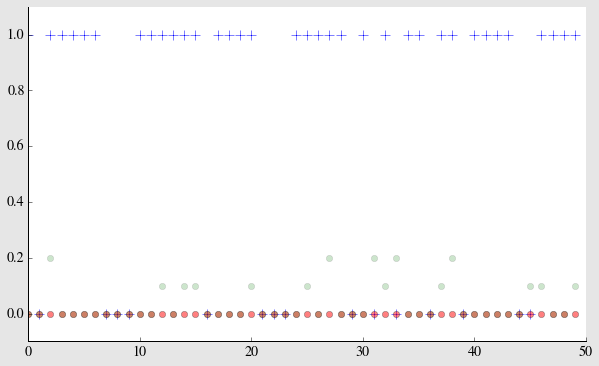

In [13]:
# a quick look at the results
plt.plot(full_results.actual[50:100], 'b+', markersize=10)
plt.plot(full_results.predicted[50:100], 'ro', alpha = 0.5)
plt.plot(full_results.proba[50:100], 'go', alpha = 0.2)
plt.ylim(-0.1,1.1)
remove_border()

#### Remark
If I set the threshold looooooow, I get OK resuls from the random forest.

Precision: 0.55
Recall: 0.42
ROC-AUC: 0.58


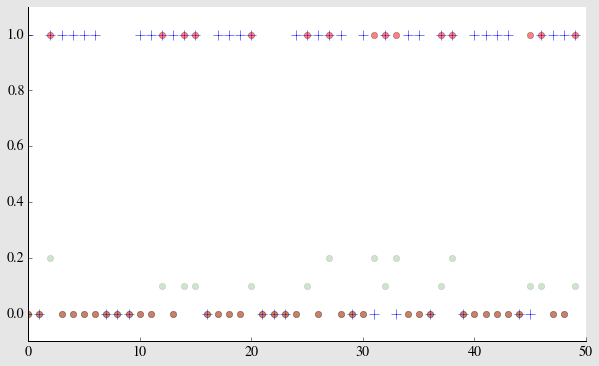

In [15]:
print "Precision: %.2f" % (sklearn.metrics.precision_score(full_results.actual,full_results.proba > 0.02))
print "Recall: %.2f" % (sklearn.metrics.recall_score(full_results.actual,full_results.proba > 0.02))
print "ROC-AUC: %.2f" % (sklearn.metrics.roc_auc_score(full_results.actual, full_results.proba))
# a quick look at the results
plt.plot(full_results.actual[50:100], 'b+', markersize=10)
plt.plot((full_results.proba > 0.02)[50:100], 'ro', alpha = 0.5)
plt.plot((full_results.proba)[50:100], 'go', alpha = 0.2)
plt.ylim(-0.1,1.1)
remove_border()

## Parameter results

*Dot classifiers for single answers*

*Repetitive Weighting*

    number of folds trained 5/5
    cutoff = 3
    num_topics = 50
    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
              intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
    Precision: 0.50
    Recall: 0.61
    ROC-AUC: 0.57

*Multiplicative Weighting*

    number of folds trained 5/5
    cutoff = 3
    num_topics = 100
    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
              intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
    Precision: 0.52
    Recall: 0.71
    ROC-AUC: 0.59

    number of folds trained 2/5
    cutoff = 3
    num_topics = 50
    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
              intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
    Precision: 0.66
    Recall: 0.63
    
    number of folds trained 5/5
    cutoff = 3
    num_topics = 50
    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
              intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
    Precision: 0.51
    Recall: 0.64
    ROC-AUC: 0.57
    
    cutoff = 3
    num_topics = 10
    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
              intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
    Precision: 0.50
    Recall: 0.44
    
    cutoff = 3
    num_topics = 50
    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
              intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)
    Precision: 0.00
    Recall: 0.00


##Timing results

*Laptop*
---

*post-optimize*

no multiprocessing

    number of folds trained 5/5
    cutoff = 2
    num_topics = 50
    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
              intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
    Precision: 0.70
    Recall: 0.60
    ROC-AUC: 0.58

    CPU times: user 2min 55s, sys: 10.5 s, total: 3min 5s
    Wall time: 2min 26s

*pre-optimize*

    (5 topics, 1 pass, 1000 iterations, 1/5 fold): 48.7s
    (5 topics, 1 pass, 1000 iterations, 5/5 folds): 4min 47s
    (100 topics, 1 pass, 1000 iterations, 5/5 folds, 'l2' penalty): 9min 18s
    
*DigitalOcean*

    (5 topics, 1 pass, 1000 iterations, 1/5 fold): 1min 17s
    (5 topics, 1 pass, 1000 iterations, 5/5 folds): 6min 15s

##Scratch 

In [14]:
from pathos.multiprocessing import Pool

In [25]:
pool = Pool(processes = 2)

In [17]:
rc.train()

Training...
 ...created the dictionary.
 ...vectorized the corpus.
 ...training the LDA model on 100 topics in 1 passes and 1000 iterations.


 ...trained the LDA model.
Done training!


In [26]:
%%time
test = test_dfs['questions'][0].title + " " + test_dfs['questions'][0].question
test = pool.map(rc.post2LDAvec, test)
test = pool.map(rc.LDAvec2ndarray, test)

CPU times: user 22.6 s, sys: 1.83 s, total: 24.5 s
Wall time: 23.1 s


In [27]:
%%time
test = test_dfs['questions'][0].title + " " + test_dfs['questions'][0].question
test = test.map(rc.post2LDAvec)
test = test.map(rc.LDAvec2ndarray)

CPU times: user 310 ms, sys: 11.1 ms, total: 321 ms
Wall time: 183 ms


In [24]:
test

post_id
5          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7          [0.0, 0.0, 0.0, 0.0348782743584, 0.0, 0.0, 0.0...
19         [0.0, 0.0704338052901, 0.0, 0.0, 0.0, 0.0, 0.0...
22         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
20         [0.0, 0.781437095963, 0.0, 0.0, 0.0, 0.0, 0.0,...
14         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
38         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
41         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
35         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.030...
16         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.54388489...
50         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
52         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
59         [0.0, 0.0890592107778, 0.0358313753715, 0.0, 0...
61         [0.0, 0.791656660284, 0.0, 0.0, 0.0, 0.0, 0.0,...
69         [0.0, 0.0462627151471, 0.0, 0.0, 0.0, 0.0, 0.0...
...
199        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
189        [